아래 두 개의 파일(Hotel_reviews_20k.csv, Hotel_reviews.csv)을 다운 받아 20,000개 혹은 전체 147,344개의 호텔 리뷰 (review_full) 및 rating값 (rating_review)을 확인해보고 Deep learning 모델을 활용하여 분석하시오.

# 1번 문제

(1) 짝수 번째 행의 리뷰를 training데이터로 사용하여 모델을 만들고 홀수 번째 행의 호텔 리뷰를 가지고 rating값을 예측하는 모델을 만들어보시오. 

In [ ]:
# 코딩을 위한 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
nltk.download('all')

In [2]:
# google drive와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load pickle data Hotel_reviews_full 가져오기
with open("/content/drive/MyDrive/Colab Notebooks/data.pickle","rb") as fr:
  data = pickle.load(fr)
data.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


5    72258
4    50170
3    15915
2     4551
1     4450
Name: rating_review, dtype: int64


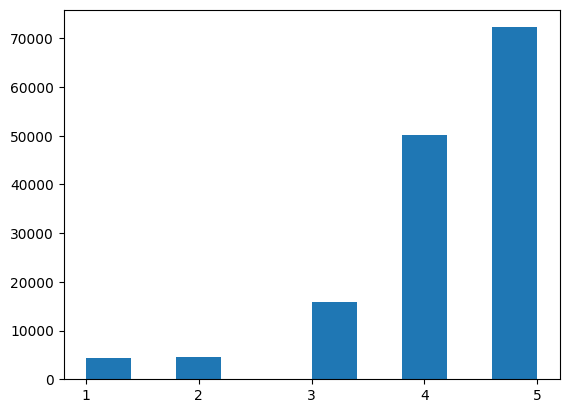

In [6]:
# rating별 리뷰 수
print(data.rating_review.value_counts())
# 'rating별 리뷰 수'의 히스토그램
plt.hist(data['rating_review'])
plt.xticks(range(1,6))
plt.show()

In [7]:
# 인덱스가 0부터 시작이므로 홀수 인덱스를 짝수행 데이터로 만듦
even_row = data[data.index % 2 == 1]
odd_row = data[data.index % 2 == 0]

In [8]:
# train data(짝수행 데이터)
train_even_X = even_row['review_full']
train_even_Y = even_row['rating_review']

# test data(홀수행 데이터)
test_odd_X = odd_row['review_full']
test_odd_Y = odd_row['rating_review']

In [9]:
# train & test data 'rating_review'의 원핫인코딩
train_even_Y = pd.get_dummies(train_even_Y)
test_odd_Y = pd.get_dummies(test_odd_Y)

In [10]:
# 리뷰 문장을 전처리하는 함수
def clean_str(data):

    # 영문자 이외 문자는 공백으로 변환
    only_english = re.sub('[^a-zA-Z]', ' ', str(data))

    # 소문자 변환
    no_capitals = only_english.lower().split()

    # 불용어(is, the, a 와 같은 의미없는 단어) 제거
    stops = set(stopwords.words('english'))
    no_stops = [word for word in no_capitals if not word in stops]

    # 어간 추출
    stemmer = nltk.stem.SnowballStemmer('english')
    stemmer_words = [stemmer.stem(word) for word in no_stops]

    return stemmer_words

In [11]:
# 문장 전처리
clean_train_even_X = [clean_str(sentence) for sentence in train_even_X]
clean_test_odd_X = [clean_str(sentence) for sentence in test_odd_X]
# clean_train_even_X

In [12]:
# 단어의 희귀도 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_even_X)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43370
등장 빈도가 2번 이하인 희귀 단어의 수: 27000
단어 집합에서 희귀 단어의 비율: 62.255014987318425
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1186659007432938


In [13]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 16371


In [14]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_even_X)
train_X = tokenizer.texts_to_sequences(clean_train_even_X)
test_X = tokenizer.texts_to_sequences(clean_test_odd_X)
print(train_X[0])

[50, 104, 67, 342, 753, 1184, 479, 4, 15, 3, 11091, 4006, 10, 33, 2049, 116, 8, 61, 32]


In [15]:
# 각 샘플의 길이가 0인 샘플들의 인덱스
drop_train = [index for index, sentence in enumerate(train_X) if len(sentence) < 1]

# 빈도수가 적은 단어로만 이루어졌던 샘플의 길이가 0인 샘플 제거
train_X = np.delete(train_X, drop_train, axis=0)
train_Y = np.delete(train_even_Y, drop_train, axis=0)
print(len(train_X))
print(len(train_Y))

73672
73672


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 824
리뷰의 평균 길이 : 38.55220436529482


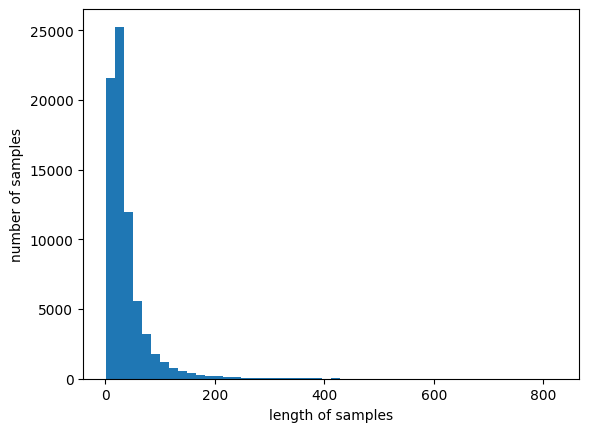

In [16]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :',max(len(review) for review in train_X))
print('리뷰의 평균 길이 :',sum(map(len, train_X))/len(train_X))
plt.hist([len(review) for review in train_X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [18]:
# max_len = 100이 약 95% 의 샘플을 포함한다.
max_len = 100
below_threshold_len(max_len, train_X)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.24747529590618


In [19]:
# 모든 샘플의 길이를 100으로 맞추기
train_X = pad_sequences(train_X, maxlen=max_len)
test_X = pad_sequences(test_X, maxlen=max_len)

In [20]:
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=100),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=5, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2095488   
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 2,227,717
Trainable params: 2,227,717
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 모델 학습
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
403/403 [==============================] - 54s 107ms/step - loss: 1.0093 - accuracy: 0.5362 - val_loss: 0.7291 - val_accuracy: 0.6814
Epoch 2/5
403/403 [==============================] - 19s 46ms/step - loss: 0.8587 - accuracy: 0.6109 - val_loss: 0.7241 - val_accuracy: 0.6822
Epoch 3/5
403/403 [==============================] - 10s 25ms/step - loss: 0.8304 - accuracy: 0.6269 - val_loss: 0.7502 - val_accuracy: 0.6667
Epoch 4/5
403/403 [==============================] - 9s 23ms/step - loss: 0.8081 - accuracy: 0.6389 - val_loss: 0.7216 - val_accuracy: 0.6874
Epoch 5/5
403/403 [==============================] - 11s 28ms/step - loss: 0.7930 - accuracy: 0.6464 - val_loss: 0.7246 - val_accuracy: 0.6876


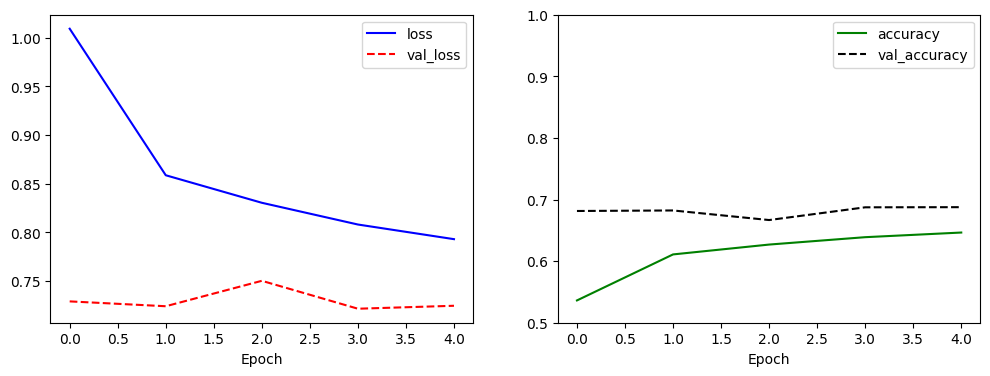

In [22]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

In [23]:
# 테스트 데이터 정확도
print("테스트 정확도: %.4f" % (model.evaluate(test_X, test_odd_Y,verbose=0)[1]))

테스트 정확도: 0.6418


In [24]:
# 홀수행 리뷰 점수 예측값 확인
predict_rating = model.predict(test_X,verbose=0)
predict_rating

array([[1.0861575e-04, 1.8876216e-04, 1.7576808e-03, 5.4634862e-02,
        9.4331014e-01],
       [1.6605627e-03, 2.3656113e-03, 1.8657744e-02, 2.2391507e-01,
        7.5340104e-01],
       [1.8462019e-04, 2.6348900e-04, 1.5184972e-03, 4.5683153e-02,
        9.5235032e-01],
       ...,
       [2.2047540e-04, 4.6083334e-04, 6.3285143e-03, 1.7819203e-01,
        8.1479818e-01],
       [3.2614570e-04, 4.2299234e-04, 1.9839753e-03, 4.1508775e-02,
        9.5575815e-01],
       [3.0725939e-02, 4.8496708e-02, 2.6526973e-01, 4.2611456e-01,
        2.2939308e-01]], dtype=float32)

In [25]:
# 확률이 높게 나온 것을 1로 바꾸고 나머지를 0으로 표현
for score in predict_rating:
    for i in range(5):
        if score[i] < max(score):
            score[i] = 0
        elif score[i] == max(score):
            score[i] = 1
predict_rating

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [26]:
# 홀수행과 비교를 위해 데이터프레임으로 변경
df_predict_rating = pd.DataFrame(predict_rating)
# 컬럼의 이름 바꿔줌
df_predict_rating.columns=[1,2,3,4,5]
# 인덱스를 홀수행 인덱스에 맞게 변경
l = np.arange(0,147343,2)
df_predict_rating = df_predict_rating.set_index(keys=[l], inplace=False)

In [27]:
# 예측한 홀수행 리뷰점수랑 실제 홀수행 리뷰점수랑 다른 부분 찾아서 인덱스 출력하는 함수
def GetDifferences(df1, df2):
  df = pd.concat([df1, df2]).reset_index(drop=False)
  idx = [diff[0] for diff in df.groupby(list(df.columns)).groups.values() if len(diff) == 1]
  return df.reindex(idx)

In [28]:
# 예측한 홀수행 점수랑 실제 홀수행 리뷰점수랑 다른 부분 찾아서 인덱스 출력
diff_rating_index = GetDifferences(test_odd_Y.astype('float'),df_predict_rating)
diff_rating_index.set_index('index',inplace=True)
diff_rating_index.reset_index()
diff_rating_index

,1,2,3,4,5
index,,,,,
10,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,0.0,1.0,0.0
32,0.0,0.0,0.0,0.0,1.0
32,0.0,0.0,0.0,1.0,0.0
54,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
147298,0.0,0.0,0.0,1.0,0.0
147322,0.0,0.0,0.0,0.0,1.0
147322,0.0,0.0,0.0,1.0,0.0


### 결과 : 데이터를 확인해보니 1점 차이나는 구분을 많이 틀렸다. 1점의 차이는 정확하게 구별하기 어려운 것으로 판단할 수 있다.

# 2번 문제

(2) 호텔의 리뷰 및 rating값을 이용하여 어떤 단어가 좋은 호텔 리뷰에 많이 쓰이고 어떤 단어가 나쁜 호텔 리뷰에 많이 쓰이는지 분석해 보고 어떤 요소가 호텔 평가에 많은 영향을 미치는지 논의해 보시오.

In [29]:
# 1,2,3 점은 0으로 4,5 점은 1로 바꿈
data['labels'] = [1 if data['rating_review'][i] >= 4 else 0 for i in range(len(data['rating_review']))]
data.head()

,rating_review,review_full,labels
0,5,"Totally in love with the Auro of the place, re...",1
1,5,I went this bar 8 days regularly with my husba...,1
2,5,We were few friends and was a birthday celebra...,1
3,5,Fatjar Cafe and Market is the perfect place fo...,1
4,5,"Hey Guys, if you are craving for pizza and sea...",1


In [30]:
# 1,2,3 점은 data_bad로 4,5 점은 data_good로 데이터 나눔
data_good = data[data['rating_review'] >= 4]
data_bad = data[data['rating_review'] < 4]

In [31]:
# 리뷰 문장을 전처리하는 함수
def clean_str(data):

    # 영문자 이외 문자는 공백으로 변환
    only_english = re.sub('[^a-zA-Z]', ' ', str(data))

    # 소문자 변환
    no_capitals = only_english.lower().split()

    # 불용어(is, the, a 와 같은 의미없는 단어) 제거
    stops = set(stopwords.words('english'))
    no_stops = [word for word in no_capitals if not word in stops]
    
    return no_stops

In [32]:
# 문장 전처리
good_sentences = data_good['review_full']
bad_sentences = data_bad['review_full']
clean_good_sentences = [clean_str(sentence) for sentence in good_sentences]
clean_bad_sentences = [clean_str(sentence) for sentence in bad_sentences]

In [35]:
# 단어들 모두 다 한 리스트로 합치기
all_good_words = []
for i in range(len(clean_good_sentences)):
    all_good_words += clean_good_sentences[i]
all_bad_words = []
for i in range(len(clean_bad_sentences)):
    all_bad_words += clean_bad_sentences[i]

In [36]:
# WordNetLemmatizer() 함수를 사용하여 원형으로 추출
wlem = nltk.WordNetLemmatizer()
lemma_good_words = []
for word in all_good_words:
    new_word = wlem.lemmatize(word)
    lemma_good_words.append(new_word)
lemma_bad_words = []
for word in all_bad_words:
    new_word = wlem.lemmatize(word)
    lemma_bad_words.append(new_word)

In [37]:
# 좋은 리뷰와 나쁜 리뷰에 나오는 top 500 단어와 빈도 추출
count_good = Counter(lemma_good_words)
most_good = Counter(dict(count_good.most_common(500)))
count_bad = Counter(lemma_bad_words)
most_bad = Counter(dict(count_bad.most_common(500)))

In [38]:
# 좋은 리뷰 top 500와 나쁜 리뷰 top 500에 공통으로 나오는 단어 추출
inter_words = Counter(dict(most_good))&Counter(dict(most_bad))

In [39]:
# 좋은 리뷰 top 500에서 나쁜 리뷰와 공통으로 나오는 단어 제거
keys_to_remove = list(dict(inter_words).keys())
for key in keys_to_remove:
  del most_good[key]
most_good_not_bad = most_good.most_common()
print(most_good_not_bad)

[('lovely', 5906), ('wonderful', 5724), ('thanks', 5478), ('courteous', 4718), ('mr', 4705), ('helpful', 4442), ('favourite', 4258), ('mouth', 4140), ('hospitality', 4034), ('lover', 3837), ('attentive', 3817), ('fantastic', 3782), ('specially', 3752), ('superb', 3714), ('yummy', 3658), ('super', 3568), ('team', 3459), ('crispy', 3333), ('selection', 3296), ('thank', 3208), ('soon', 3181), ('unique', 3027), ('simply', 2931), ('warm', 2865), ('comfortable', 2735), ('polite', 2704), ('everyone', 2684), ('spread', 2682), ('sushi', 2671), ('grilled', 2615), ('makhani', 2590), ('favorite', 2536), ('birthday', 2491), ('miss', 2463), ('stay', 2458), ('perfectly', 2455), ('weekend', 2424), ('dine', 2385), ('asian', 2344), ('interesting', 2325), ('making', 2313), ('yet', 2295), ('outstanding', 2291), ('choose', 2275), ('pleasant', 2265), ('prompt', 2256), ('veggie', 2246), ('heart', 2241), ('set', 2186), ('recently', 2157), ('traditional', 2139), ('delight', 2136), ('wide', 2123), ('preparation

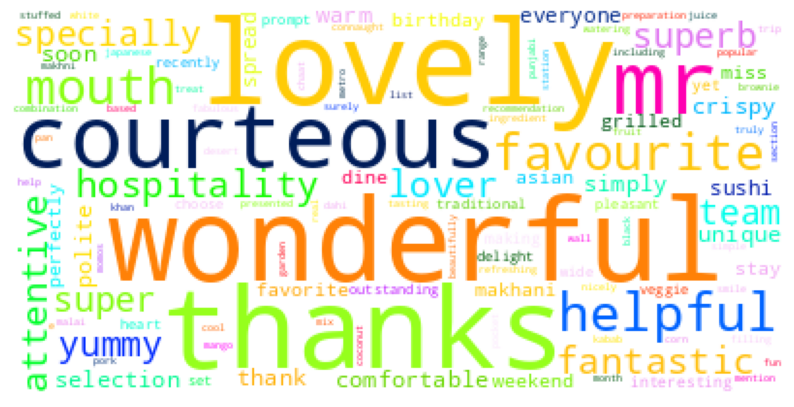

In [40]:
# 좋은 리뷰 top 500에서 나쁜 리뷰와 공통으로 나오는 단어 시각화
wc_good = WordCloud(background_color="white", max_font_size=60, colormap="gist_ncar_r")
cloud = wc_good.generate_from_frequencies(dict(most_good_not_bad))
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [41]:
# 나쁜 리뷰 top 500에서 좋은 리뷰와 공통으로 나오는 단어 제거
keys_to_remove = list(dict(inter_words).keys())
for key in keys_to_remove:
  del most_bad[key]
most_bad_not_good = most_bad.most_common()
print(most_bad_not_good)

[('bad', 3037), ('bill', 1889), ('said', 1567), ('poor', 1537), ('told', 1527), ('charge', 1216), ('left', 1177), ('worst', 1126), ('half', 990), ('pathetic', 957), ('expectation', 925), ('min', 919), ('disappointing', 915), ('okay', 913), ('seemed', 875), ('pay', 874), ('rather', 851), ('expect', 803), ('called', 803), ('expected', 798), ('limited', 789), ('please', 771), ('avoid', 762), ('call', 759), ('seems', 749), ('heard', 745), ('loud', 744), ('finally', 734), ('mark', 717), ('management', 711), ('maybe', 709), ('arrived', 706), ('terrible', 691), ('put', 669), ('paid', 668), ('probably', 666), ('reason', 660), ('rude', 655), ('tax', 655), ('instead', 653), ('change', 647), ('dont', 644), ('bland', 637), ('disappointment', 636), ('cheap', 621), ('empty', 616), ('either', 613), ('dry', 609), ('overpriced', 599), ('might', 597), ('gone', 596), ('extra', 596), ('seat', 595), ('tasteless', 591), ('rest', 590), ('bottle', 575), ('card', 572), ('wrong', 558), ('leave', 553), ('horribl

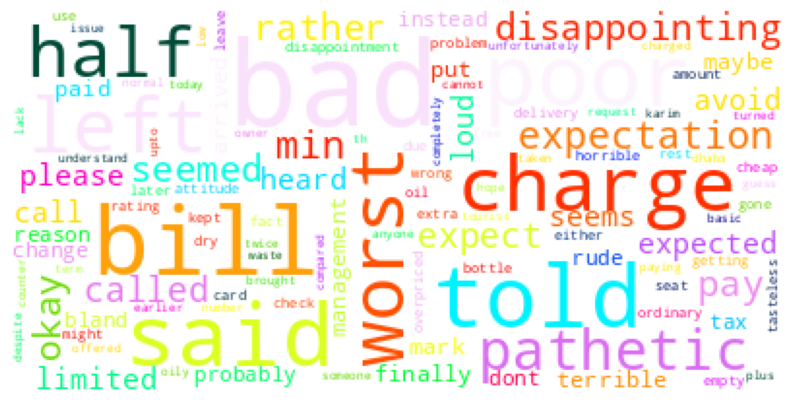

In [42]:
# 나쁜 리뷰 top 500에서 좋은 리뷰와 공통으로 나오는 단어 시각화
wc_bad = WordCloud(background_color="white", max_font_size=60, colormap="gist_ncar_r")
cloud = wc_bad.generate_from_frequencies(dict(most_bad_not_good))
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 결과 : 단어들을 보면 좋은 리뷰에는 긍정적인 단어가 많은것에 비해 나쁜 리뷰에는 부정적인 단어가 많은 것을 볼 수 있다.

# 3번 문제

(3) 주어진 호텔 리뷰 데이터를 가지고 할 수 있는 분석이 있으면 더 진행해보시오.
---> 짝수 번째 행의 리뷰를 training데이터로 사용하여 모델을 만들고 홀수 번째 행의 호텔 리뷰를 가지고 좋은 리뷰, 나쁜 리뷰을 예측하는 모델을 만들어보시오. 

In [43]:
# 1,2,3 점은 0으로 4,5 점은 1로 바꿈
data['labels'] = [1 if data['rating_review'][i] >= 4 else 0 for i in range(len(data['rating_review']))]
data.head()

,rating_review,review_full,labels
0,5,"Totally in love with the Auro of the place, re...",1
1,5,I went this bar 8 days regularly with my husba...,1
2,5,We were few friends and was a birthday celebra...,1
3,5,Fatjar Cafe and Market is the perfect place fo...,1
4,5,"Hey Guys, if you are craving for pizza and sea...",1


In [44]:
# 인덱스가 0부터 시작이므로 홀수 인덱스를 짝수행 데이터로 만듦
even_row = data[data.index % 2 == 1]
odd_row = data[data.index % 2 == 0]

In [45]:
# train data(짝수행 데이터)
train_even_Y = even_row['labels']

# test data(홀수행 데이터)
test_odd_Y = odd_row['labels']

In [46]:
# train & test data 'rating_review'의 원핫인코딩
train_even_Y = pd.get_dummies(train_even_Y)
test_odd_Y = pd.get_dummies(test_odd_Y)

In [47]:
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=100),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2095488   
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2,227,330
Trainable params: 2,227,330
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 모델 학습
history = model.fit(train_X, train_even_Y, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5
403/403 [==============================] - 37s 86ms/step - loss: 0.3260 - accuracy: 0.8721 - val_loss: 0.2138 - val_accuracy: 0.9221
Epoch 2/5
403/403 [==============================] - 14s 35ms/step - loss: 0.2600 - accuracy: 0.9036 - val_loss: 0.2114 - val_accuracy: 0.9231
Epoch 3/5
403/403 [==============================] - 9s 21ms/step - loss: 0.2466 - accuracy: 0.9091 - val_loss: 0.2081 - val_accuracy: 0.9246
Epoch 4/5
403/403 [==============================] - 9s 22ms/step - loss: 0.2372 - accuracy: 0.9125 - val_loss: 0.2113 - val_accuracy: 0.9237
Epoch 5/5
403/403 [==============================] - 6s 15ms/step - loss: 0.2305 - accuracy: 0.9156 - val_loss: 0.2056 - val_accuracy: 0.9254


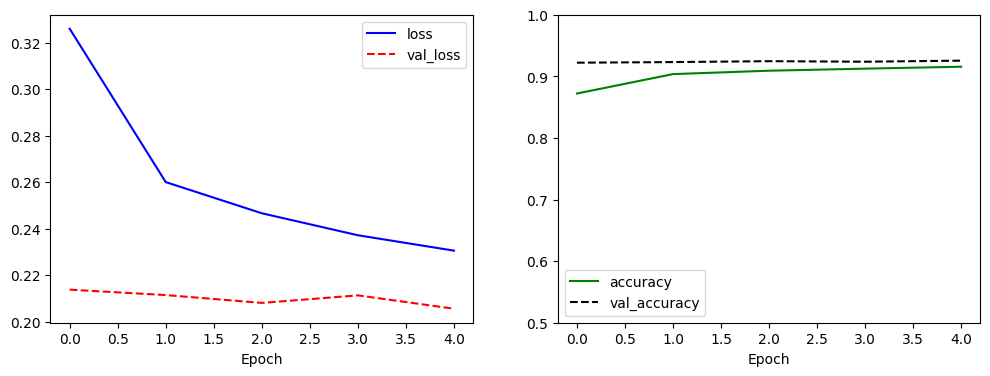

In [49]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.5, 1)
plt.legend()
plt.show()

In [50]:
# 테스트 데이터 정확도
print("테스트 정확도: %.4f" % (model.evaluate(test_X, test_odd_Y,verbose=0)[1]))

테스트 정확도: 0.9109
